In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag

import gensim
from gensim.models import Word2Vec,FastText

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

from sklearn.preprocessing import LabelEncoder
import umap.umap_ as umap


c:\Users\Rarou\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Chargement des données
df = pd.read_csv('medical_text.csv', encoding='ISO-8859-1')

In [3]:
# Restructuration du dataframe
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'0':'label','a':'text'},inplace=True)

In [4]:
df

,label,text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...
...,...,...
7565,Colon_Cancer,we report the case of a 24yearold man who pres...
7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7567,Colon_Cancer,the heterogeneity of cancer cells is generally...
7568,Colon_Cancer,"""adipogenesis is the process through which mes..."


# 1.Analysis of the text dataset

## Analyse du dataset

Le dataset utilisé dans ce projet provient du domaine biomédical et concerne la classification de documents scientifiques liés à différents types de cancer. Il se compose de 7569 articles de recherche complets, chacun ayant une longueur supérieure à 6 pages, ce qui reflète une complexité plus élevée que les résumés ou articles plus courts généralement utilisés dans les tâches similaires. Les documents sont répartis en trois catégories correspondant à des types de cancer : 
- **Thyroid_Cancer (2810 documents)**
- **Colon_Cancer (2579 documents)**
- **Lung_Cancer (2180 documents)**

L'objectif principal est de développer un modèle de classification performant capable de distinguer ces trois catégories à partir du contenu textuel des publications. Le contexte biomédical ajoute un niveau de difficulté important, notamment en raison de la richesse du vocabulaire technique, de la longueur des textes, et de la similarité sémantique possible entre les documents. Ce projet représente donc un défi intéressant pour évaluer et comparer différentes techniques de représentation de texte et de classification dans le domaine du NLP appliqué à la santé.


In [6]:
print(f"Nombre total de documents : {len(df)}")
print(f"Répartition des classes :\n{df['label'].value_counts()}")
print("\nExemple de texte brut :\n", df['text'].iloc[0])
print(f"Longueur moyenne des textes : {int(np.round(df['text'].apply(len).mean()))} mots")

Nombre total de documents : 7570
Répartition des classes :
label
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

Exemple de texte brut :
 Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S Thyroid surgery in  children  in  a  single  institution  from 

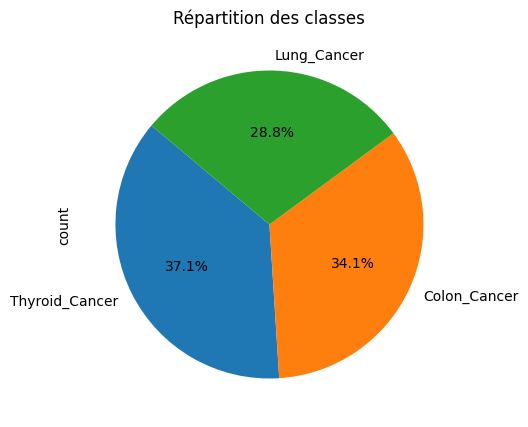

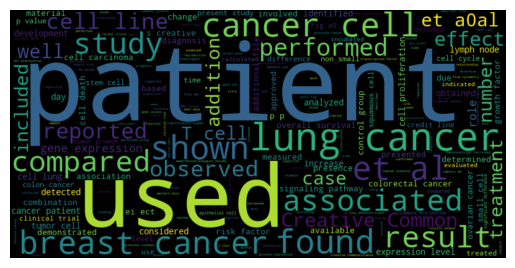

In [8]:
# Distribution des classes
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Répartition des classes")
plt.show()

# Nuage de mots fréquents
text_all = " ".join(df['text'])
wordcloud = WordCloud(width=800, height=400).generate(text_all)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#

# 2.Text processing and Transformation

In [ ]:
"""
    On veut déterminer si le mot est:
        - un adverbe
        - verbe 
        - nom 
        - adjectif 
    afin de le retourner à sa forme canonique
"""

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return ''

In [ ]:
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')

In [ ]:
"""
    Fonction qui transforme le texte brut en text processé en mots pour l'adapter à nos méthodes d'embedding
"""

def preprocess_text(text):
    text = re.sub("\[.+\]","",text)

    #Tokenization du texte
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    data_processed = []

    #On applique la fonction wordnet et lemmatizer
    for i, word in enumerate(tokens):
        pos = get_wordnet_pos(pos_tag([word])[0][1])
        if pos != '':
            data_processed.append(lemmatizer.lemmatize(word, pos))
        else:
            data_processed.append(word)

    #On enlève les stopwords
    data_processed = [word.lower() for word in data_processed if word.isalpha()]
    data_processed = [word for word in data_processed if not word in stopwords.words('english')]

    return data_processed

In [ ]:
#df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
#On sauvegarde le texte processed pour ne plus le recompiler
#df.to_excel('medical_text_processed.xlsx', index=False)

In [2]:
# Chargement des données processed
df_processed = pd.read_excel('medical_text_processed.xlsx')

In [3]:
df = df_processed.copy()

In [27]:
#Présentation du text après traitement
df_processed

,label,text,processed_text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,"['thyroid', 'surgery', 'child', 'single', 'ins..."
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...","['adopt', 'strategy', 'use', 'prior', 'year', ..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,"['coronary', 'arterybypass', 'graft', 'thrombo..."
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,"['solitary', 'plasmacytoma', 'sp', 'skull', 'u..."
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,"['study', 'aim', 'investigate', 'serum', 'matr..."
...,...,...,...
7565,Colon_Cancer,we report the case of a 24yearold man who pres...,"['report', 'case', 'man', 'present', 'chief', ..."
7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...,"['among', 'synchronous', 'colorectal', 'cancer..."
7567,Colon_Cancer,the heterogeneity of cancer cells is generally...,"['heterogeneity', 'cancer', 'cell', 'generally..."
7568,Colon_Cancer,"""adipogenesis is the process through which mes...","['adipogenesis', 'process', 'mesenchymalstem',..."


# 3. Apply different embedding techniques

In [14]:
#Instanciation de la variable cible
y = df['label']

### TF-IDF

In [24]:
df_processed['processed_text'] = df_processed['processed_text'].apply(''.join)

In [25]:
#Vectorisation du texe
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_processed['processed_text'])

In [26]:
#On transforme notre vecteur en vecteur transformé par la méthode tf idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

### Word2Vec

In [ ]:
#Préparation des données pour fastext
sentences = [sentence.split() for sentence in df_processed['processed_text']]

In [20]:
#Instanciation du modèle word 2 vec
word_2_vec = Word2Vec(sentences=sentences, min_count=1, vector_size=100,
                                window=5, sg=1)

In [21]:
"""
    On vectorize les tokens pui on calcule la moyenne des vectorisations des mots
"""
# def vectorize(sentence,model):
#     words = sentence.split()
#     words_vecs = [word_2_vec.wv[word] for word in words if word in word_2_vec.wv]
#     if len(words_vecs) == 0:
#         return np.zeros(100)
#     words_vecs = np.array(words_vecs)
    
#     return words_vecs.mean(axis=0)

def vectorize(sentence,model):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    
    return words_vecs.mean(axis=0)

In [23]:
#On transforme notre vecteur en vecteur transformé par la méthode word 2 vec
X_word2vec = np.array([vectorize(sentence,word_2_vec) for sentence in df_processed['processed_text']])

### Fast text

In [7]:
fastext = FastText(sentences,min_count=1, vector_size=128,workers=4,epochs=10,seed=42,window=5, sg=1)

In [10]:
fastext.save('fastext_model.ft')

In [9]:
X_fastext = np.array([vectorize(sentence,fastext) for sentence in df_processed['processed_text']])

In [12]:
X_fastext.shape

(7570, 128)

# 4. Clustering and/or classification on the embedded data

### Support Vector Machine (SVM)

In [33]:
"""
    Entraînement et évaluation avec SVM sur TF-IDF
"""

# Séparation des données en jeu de train et test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#Création du modèle SVm sur les données TF IDF
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train_tfidf)

# Prédictions sur le jeu d'entraînement
y_train_pred = svm_model.predict(X_train_tfidf)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_tfidf, y_train_pred))
print("Rapport de classification :")
print(classification_report(y_train_tfidf, y_train_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_train_tfidf, y_train_pred))

# Prédictions sur le jeu de test
y_pred_tfidf = svm_model.predict(X_test_tfidf)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print("Rapport de classification :")
print(classification_report(y_test_tfidf, y_pred_tfidf))
print("Matrice de confusion :")
print(confusion_matrix(y_test_tfidf, y_pred_tfidf))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_tfidf, y_train_pred)
test_acc = accuracy_score(y_test_tfidf, y_pred_tfidf)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")



Performance sur le jeu d'entraînement :
Accuracy: 0.9777080581241744
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.96      0.97      0.97      2063
   Lung_Cancer       1.00      1.00      1.00      1773
Thyroid_Cancer       0.98      0.96      0.97      2220

      accuracy                           0.98      6056
     macro avg       0.98      0.98      0.98      6056
  weighted avg       0.98      0.98      0.98      6056

Matrice de confusion :
[[2011    0   52]
 [   0 1773    0]
 [  83    0 2137]]

Performance sur le jeu de test :
Accuracy: 0.9636723910171731
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.93      0.97      0.95       517
   Lung_Cancer       1.00      1.00      1.00       407
Thyroid_Cancer       0.97      0.94      0.95       590

      accuracy                           0.96      1514
     macro avg       0.97      0.97      0.97      1514


In [34]:
"""
    Entraînement et évaluation avec SVM sur Word2Vec
"""

# Séparation des données en jeu de train et test
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

#Création du modèle SVm sur les données Word2Vec
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_word2vec, y_train_word2vec)

# Prédictions sur le jeu d'entraînement
y_pred_train_word2vec = svm_model.predict(X_train_word2vec)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_word2vec, y_pred_train_word2vec))
print("Rapport de classification :")
print(classification_report(y_train_word2vec, y_pred_train_word2vec))
print("Matrice de confusion :")
print(confusion_matrix(y_train_word2vec, y_pred_train_word2vec))

# Prédictions sur le jeu de test
y_pred_word2vec = svm_model.predict(X_test_word2vec)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_word2vec, y_pred_word2vec))
print("Rapport de classification :")
print(classification_report(y_test_word2vec, y_pred_word2vec))
print("Matrice de confusion :")
print(confusion_matrix(y_test_word2vec, y_pred_word2vec))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_word2vec, y_pred_train_word2vec)
test_acc = accuracy_score(y_test_word2vec, y_pred_word2vec)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")


Performance sur le jeu d'entraînement :
Accuracy: 0.7575957727873184
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.69      0.72      0.71      2063
   Lung_Cancer       0.89      0.91      0.90      1773
Thyroid_Cancer       0.70      0.67      0.69      2220

      accuracy                           0.76      6056
     macro avg       0.76      0.77      0.77      6056
  weighted avg       0.76      0.76      0.76      6056

Matrice de confusion :
[[1482   55  526]
 [  54 1622   97]
 [ 599  137 1484]]

Performance sur le jeu de test :
Accuracy: 0.7410832232496698
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.66      0.73      0.69       517
   Lung_Cancer       0.88      0.88      0.88       407
Thyroid_Cancer       0.72      0.65      0.69       590

      accuracy                           0.74      1514
     macro avg       0.75      0.75      0.75      1514


In [15]:
"""
    Entraînement et évaluation avec SVM sur Fastext
"""

# Séparation des données en jeu de train et test
X_train_fastext, X_test_fastext, y_train_fastext, y_test_fastext = train_test_split(X_fastext, y, test_size=0.2, random_state=42)

#Création du modèle SVm sur les données fastext
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_fastext, y_train_fastext)

# Prédictions sur le jeu d'entraînement
y_pred_train_fastext = svm_model.predict(X_train_fastext)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_fastext, y_pred_train_fastext))
print("Rapport de classification :")
print(classification_report(y_train_fastext, y_pred_train_fastext))
print("Matrice de confusion :")
print(confusion_matrix(y_train_fastext, y_pred_train_fastext))

# Prédictions sur le jeu de test
y_pred_fastext = svm_model.predict(X_test_fastext)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_fastext, y_pred_fastext))
print("Rapport de classification :")
print(classification_report(y_test_fastext, y_pred_fastext))
print("Matrice de confusion :")
print(confusion_matrix(y_test_fastext, y_pred_fastext))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_fastext, y_pred_train_fastext)
test_acc = accuracy_score(y_test_fastext, y_pred_fastext)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")


Performance sur le jeu d'entraînement :
Accuracy: 0.8228203434610304
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.76      0.82      0.79      2063
   Lung_Cancer       0.90      0.93      0.92      1773
Thyroid_Cancer       0.82      0.74      0.78      2220

      accuracy                           0.82      6056
     macro avg       0.83      0.83      0.83      6056
  weighted avg       0.82      0.82      0.82      6056

Matrice de confusion :
[[1688   63  312]
 [  71 1647   55]
 [ 458  114 1648]]

Performance sur le jeu de test :
Accuracy: 0.7873183619550859
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.73      0.80      0.76       517
   Lung_Cancer       0.87      0.90      0.89       407
Thyroid_Cancer       0.78      0.70      0.74       590

      accuracy                           0.79      1514
     macro avg       0.79      0.80      0.80      1514


### Random Forest

In [12]:
"""
    Entraînement et évaluation avec SVM sur TF IDF
"""

# Séparation des données en jeu de train et test
X_train_rf_tfidf , X_test_rf_tfidf , y_train_rf_tfidf , y_test_rf_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Instanciation du modèle random forest
rf_model = RandomForestClassifier( max_depth=2, random_state=42)
rf_model.fit(X_train_rf_tfidf,y_train_rf_tfidf)

# Prédictions sur le jeu d'entraînement
y_train_rf_pred_tfidf = rf_model.predict(X_train_rf_tfidf)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_rf_tfidf, y_train_rf_pred_tfidf))
print("Rapport de classification :")
print(classification_report(y_train_rf_tfidf, y_train_rf_pred_tfidf))
print("Matrice de confusion :")
print(confusion_matrix(y_train_rf_tfidf, y_train_rf_pred_tfidf))

# Prédictions sur le jeu de test
y_pred_test_rf__tfidf = rf_model.predict(X_test_rf_tfidf)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_rf_tfidf, y_pred_test_rf__tfidf))
print("Rapport de classification :")
print(classification_report(y_test_rf_tfidf, y_pred_test_rf__tfidf))
print("Matrice de confusion :")
print(confusion_matrix(y_test_rf_tfidf, y_pred_test_rf__tfidf))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_rf_tfidf, y_train_rf_pred_tfidf)
test_acc = accuracy_score(y_test_rf_tfidf, y_pred_test_rf__tfidf)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")


Performance sur le jeu d'entraînement :
Accuracy: 0.7045904887714664
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.84      0.55      0.66      2063
   Lung_Cancer       1.00      0.64      0.78      1773
Thyroid_Cancer       0.56      0.90      0.69      2220

      accuracy                           0.70      6056
     macro avg       0.80      0.70      0.71      6056
  weighted avg       0.78      0.70      0.71      6056

Matrice de confusion :
[[1135    0  928]
 [   0 1136  637]
 [ 224    0 1996]]

Performance sur le jeu de test :
Accuracy: 0.7054161162483488
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.79      0.55      0.65       517
   Lung_Cancer       1.00      0.66      0.80       407
Thyroid_Cancer       0.58      0.87      0.70       590

      accuracy                           0.71      1514
     macro avg       0.79      0.69      0.71      1514


In [15]:
"""
    Entraînement et évaluation avec SVM sur Word2Vec
"""

# Séparation des données en jeu de train et test
X_train_rf_word2vec, X_test_rf_word2vec, y_train_rf_word2vec, y_test_rf_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

# Instanciation du modèle random forest
rf_model = RandomForestClassifier(max_depth=2, random_state=42)
rf_model.fit(X_train_rf_word2vec,y_train_rf_word2vec)

# Prédiction sur les données de train
y_pred_train_rf_word2vec = rf_model.predict(X_train_rf_word2vec)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_rf_word2vec, y_pred_train_rf_word2vec))
print("Rapport de classification :")
print(classification_report(y_train_rf_word2vec, y_pred_train_rf_word2vec))
print("Matrice de confusion :")
print(confusion_matrix(y_train_rf_word2vec, y_pred_train_rf_word2vec))

# Prédictions sur le jeu de test
y_pred_test_rf_word2vec = rf_model.predict(X_test_rf_word2vec)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_rf_word2vec, y_pred_test_rf_word2vec))
print("Rapport de classification :")
print(classification_report(y_test_rf_word2vec, y_pred_test_rf_word2vec))
print("Matrice de confusion :")
print(confusion_matrix(y_test_rf_word2vec, y_pred_test_rf_word2vec))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_rf_word2vec, y_pred_train_rf_word2vec)
test_acc = accuracy_score(y_test_rf_word2vec, y_pred_test_rf_word2vec)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")


Performance sur le jeu d'entraînement :
Accuracy: 0.6003963011889035
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.73      0.29      0.42      2063
   Lung_Cancer       0.73      0.68      0.70      1773
Thyroid_Cancer       0.51      0.82      0.63      2220

      accuracy                           0.60      6056
     macro avg       0.66      0.60      0.58      6056
  weighted avg       0.65      0.60      0.58      6056

Matrice de confusion :
[[ 601  237 1225]
 [  48 1208  517]
 [ 175  218 1827]]

Performance sur le jeu de test :
Accuracy: 0.5845442536327609
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.72      0.31      0.43       517
   Lung_Cancer       0.67      0.62      0.64       407
Thyroid_Cancer       0.52      0.80      0.63       590

      accuracy                           0.58      1514
     macro avg       0.64      0.58      0.57      1514


In [16]:
"""
    Entraînement et évaluation avec SVM sur Fastext
"""

# Séparation des données en jeu de train et test
X_train_rf_fastext, X_test_rf_fastext, y_train_rf_fastext, y_test_rf_fastext = train_test_split(X_fastext, y, test_size=0.2, random_state=42)

# Instanciation du modèle random forest
rf_model = RandomForestClassifier(max_depth=2, random_state=42)
rf_model.fit(X_train_rf_fastext,y_train_rf_fastext)

# Prédiction sur les données de train
y_pred_train_rf_fastext = rf_model.predict(X_train_rf_fastext)
print("\nPerformance sur le jeu d'entraînement :")
print("Accuracy:", accuracy_score(y_train_rf_fastext, y_pred_train_rf_fastext))
print("Rapport de classification :")
print(classification_report(y_train_rf_fastext, y_pred_train_rf_fastext))
print("Matrice de confusion :")
print(confusion_matrix(y_train_rf_fastext, y_pred_train_rf_fastext))

# Prédictions sur le jeu de test
y_pred_test_rf_fastext = rf_model.predict(X_test_rf_fastext)
print("\nPerformance sur le jeu de test :")
print("Accuracy:", accuracy_score(y_test_rf_fastext, y_pred_test_rf_fastext))
print("Rapport de classification :")
print(classification_report(y_test_rf_fastext, y_pred_test_rf_fastext))
print("Matrice de confusion :")
print(confusion_matrix(y_test_rf_fastext, y_pred_test_rf_fastext))

#Accuracy sur les jeux de train et de test
train_acc = accuracy_score(y_train_rf_fastext, y_pred_train_rf_fastext)
test_acc = accuracy_score(y_test_rf_fastext, y_pred_test_rf_fastext)

#On vérifie un possible overfitting 
overfitting_gap = train_acc - test_acc
print("\nÉcart d'accuracy entre train et test:", overfitting_gap)
if overfitting_gap > 0.1:  
    print("Attention : Possible surapprentissage détecté !")


Performance sur le jeu d'entraînement :
Accuracy: 0.5923051519154557
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.63      0.37      0.46      2063
   Lung_Cancer       0.75      0.61      0.67      1773
Thyroid_Cancer       0.51      0.79      0.62      2220

      accuracy                           0.59      6056
     macro avg       0.63      0.59      0.59      6056
  weighted avg       0.62      0.59      0.58      6056

Matrice de confusion :
[[ 761  176 1126]
 [ 158 1075  540]
 [ 296  173 1751]]

Performance sur le jeu de test :
Accuracy: 0.5528401585204755
Rapport de classification :
                precision    recall  f1-score   support

  Colon_Cancer       0.61      0.35      0.44       517
   Lung_Cancer       0.65      0.51      0.57       407
Thyroid_Cancer       0.50      0.76      0.60       590

      accuracy                           0.55      1514
     macro avg       0.59      0.54      0.54      1514


### Comparaison des résultats des deux modèles de classification


**Résultats SVM + TF-IDF**

- Accuracy (test) : 96%

- Très bonne performance sur les trois classes avec une légère confusion entre Thyroid_Cancer et Colon_Cancer.
    La matrice de confusion est parfaite pour Lung_Cancer (1.00), ce qui indique que cette classe est très bien reconnue.
    Écart d’accuracy train/test : ~1.4%, ce qui suggère qu'il n'y a pas d’overfitting.

**Résultats SVM + Word2Vec**
- Accuracy (test) : 73%

- Le modèle est significativement moins performant que le modèle TF-IDF.
    La classification reste tout de même satisfaisante, la qualité des embeddings semble moins adaptée à cette tâche.
    Le gap train/test est inférieur à 2%, ce qui suggère qu'il n'y a pas d’overfitting, mais la qualité des features Word2Vec est clairement moins efficace ici.

**Résultats SVM + Fastext**
- Accuracy (test) : 79%

- Le modèle est significativement moins performant que le modèle TF-IDF, cependant on note une amélioration par rapport à Word2Vec.
    La classification reste tout de même satisfaisante, la qualité des embeddings semble moins adaptée à cette tâche.
    Le gap train/test est bas, ce qui suggère qu'il n'y a pas d’overfitting, mais la qualité des features Fastext est clairement moins efficace ici.

**Résultats Random Forest + TF-IDF**
- Accuracy (test) : 71%

- Performance assez satisfaisantes et inférieure au SVM avec TF-IDF.
    Le ramdom forest sur TF IDF donne des résultats similaires à la combinaison SVM + Word2Vec

**Résultats Random Forest + Word2Vec**
- Accuracy (test) : 58%

- C’est une des moins bonne combinaison testée et les performances sont mauvaises.
    Le modèle peine à différencier et classifier les labels.
    La vectorisation Word2Vec semble moins performante avec un modèle de type arbre comme Random Forest.

**Résultats Random Forest + Fastext**
- Accuracy (test) : 55%

- C’est la moins bonne combinaison testée et les performances sont mauvaises.
    Le modèle peine à différencier et classifier les labels.
    La vectorisation Fastext semble moins performante avec un modèle de type arbre comme Random Forest.


Les résultats montrent clairement que le couple SVM + TF-IDF est le plus performant pour cette tâche de classification de documents biomédicaux. La représentation vectorielle TF-IDF, bien que plus simple que Word2Vec, capte mieux les caractéristiques discriminantes des textes longs, tandis que Word2Vec, qui encode le contexte sémantique, ne semble pas suffisant ici.



# 5. Results analysis and visualisation

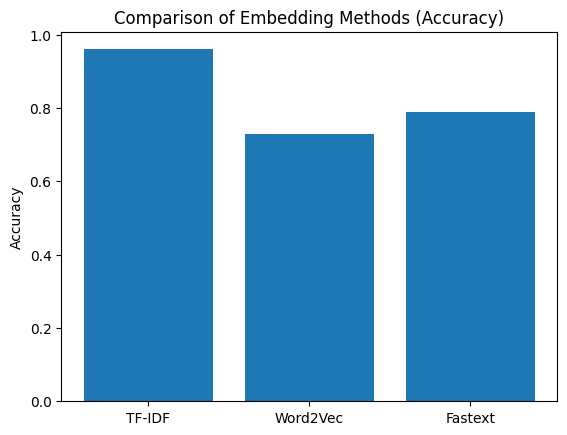

In [17]:
#Comparaison de l'accuracy entre TF IDF,Word 2 Vec et Fastext
methods = ['TF-IDF', 'Word2Vec','Fastext']
accuracies = [0.96, 0.73,0.79]

plt.bar(methods, accuracies)
plt.title('Comparison of Embedding Methods (Accuracy)')
plt.ylabel('Accuracy')
plt.show()

Pour les meilleurs modèles de machine learning associés à chaque méthode d'embedding, nous remarquons que l'accuracy de l'embedding TF-IDF est nettement supérieure à celle de Word2Vec et de Fastext. Cependant, on note une amélioration des résultats pour fastext comparé à Word2Vec

### Représentation spatiale des texts en fonction des méthodes d'embedding via UMAP

In [18]:
#Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [27]:
#On instancie le reducer UMAP et l'applique sur nos vecteurs TF IDF et Word 2 Vec
reducer = umap.UMAP(n_components=2, random_state=42)

#Transformation des vecteurs TF IDF et Word2Vec
X_umap_tfidf = reducer.fit_transform(X_tfidf)
X_umap_word2vec = reducer.fit_transform(X_word2vec)
X_umap_fastext = reducer.fit_transform(X_fastext)

c:\Users\Rarou\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


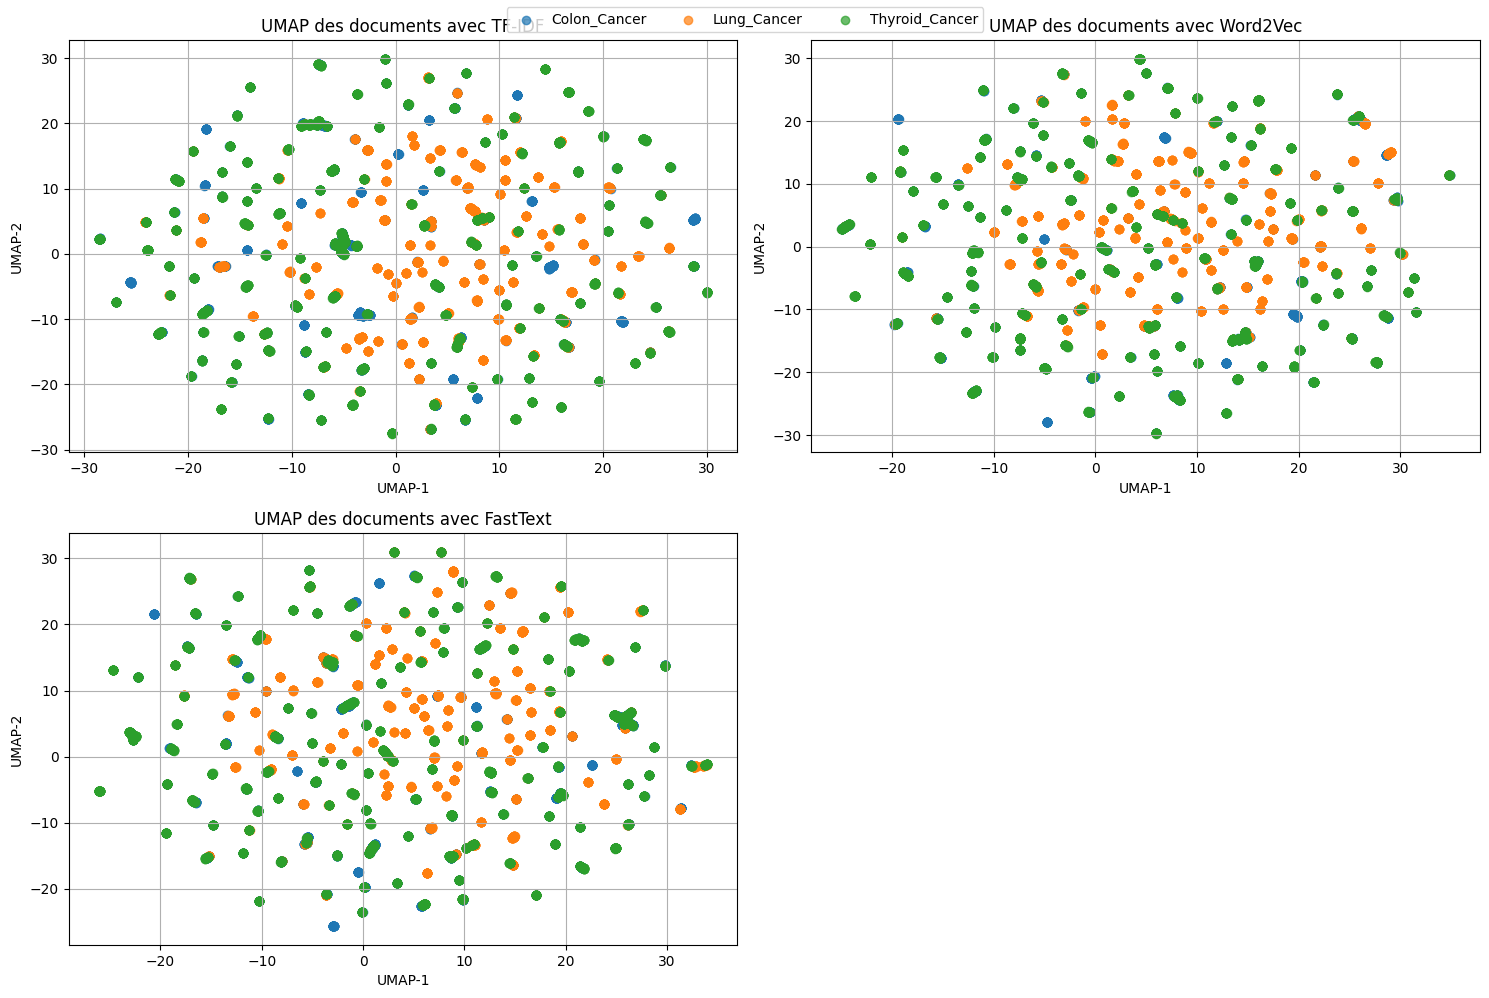

In [31]:
"""
    On veut représenter en 2D les documents via un scatter plot les documents grâce à UMAP afin de voir la similarité des docuements en fonction de leur label
    et également comment sont répartis les différents labels en fonction des méthodes d'embedding (TF IDF, Word 2 Vec)
"""

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# UMAP avec TF-IDF
for label in np.unique(y_encoded):
    idx = y_encoded == label
    axs[0, 0].scatter(X_umap_tfidf[idx, 0], X_umap_tfidf[idx, 1],
                      label=label_encoder.inverse_transform([label])[0],
                      alpha=0.7)
axs[0, 0].set_title("UMAP des documents avec TF-IDF")
axs[0, 0].set_xlabel("UMAP-1")
axs[0, 0].set_ylabel("UMAP-2")
axs[0, 0].grid(True)

# UMAP avec Word2Vec
for label in np.unique(y_encoded):
    idx = y_encoded == label
    axs[0, 1].scatter(X_umap_word2vec[idx, 0], X_umap_word2vec[idx, 1],
                      label=label_encoder.inverse_transform([label])[0],
                      alpha=0.7)
axs[0, 1].set_title("UMAP des documents avec Word2Vec")
axs[0, 1].set_xlabel("UMAP-1")
axs[0, 1].set_ylabel("UMAP-2")
axs[0, 1].grid(True)

# UMAP avec FastText
for label in np.unique(y_encoded):
    idx = y_encoded == label
    axs[1, 0].scatter(X_umap_fastext[idx, 0], X_umap_fastext[idx, 1],
                      label=label_encoder.inverse_transform([label])[0],
                      alpha=0.7)
axs[1, 0].set_title("UMAP des documents avec FastText")
axs[1, 0].set_xlabel("UMAP-1")
axs[1, 0].set_ylabel("UMAP-2")
axs[1, 0].grid(True)

fig.delaxes(axs[1, 1])

# Légendes globales
handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels))
plt.tight_layout()
plt.show()


Ce graphique montre qu'il n'est pas évident de définir la meilleure méthode d'embedding via une représentation spatiale en 2D des texts via UMAP. Cependant, les performances de ces méthodes lorsqu'elles sont couplées à des algorithmes de machine learning sont significativement différentes.

In [35]:
label_encoder = LabelEncoder()
y_tfidf_encoded = label_encoder.fit_transform(y_pred_tfidf)
y_test_encoded = label_encoder.fit_transform(y_pred_word2vec)
y_fastext_encoded = label_encoder.fit_transform(y_pred_fastext)

c:\Users\Rarou\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


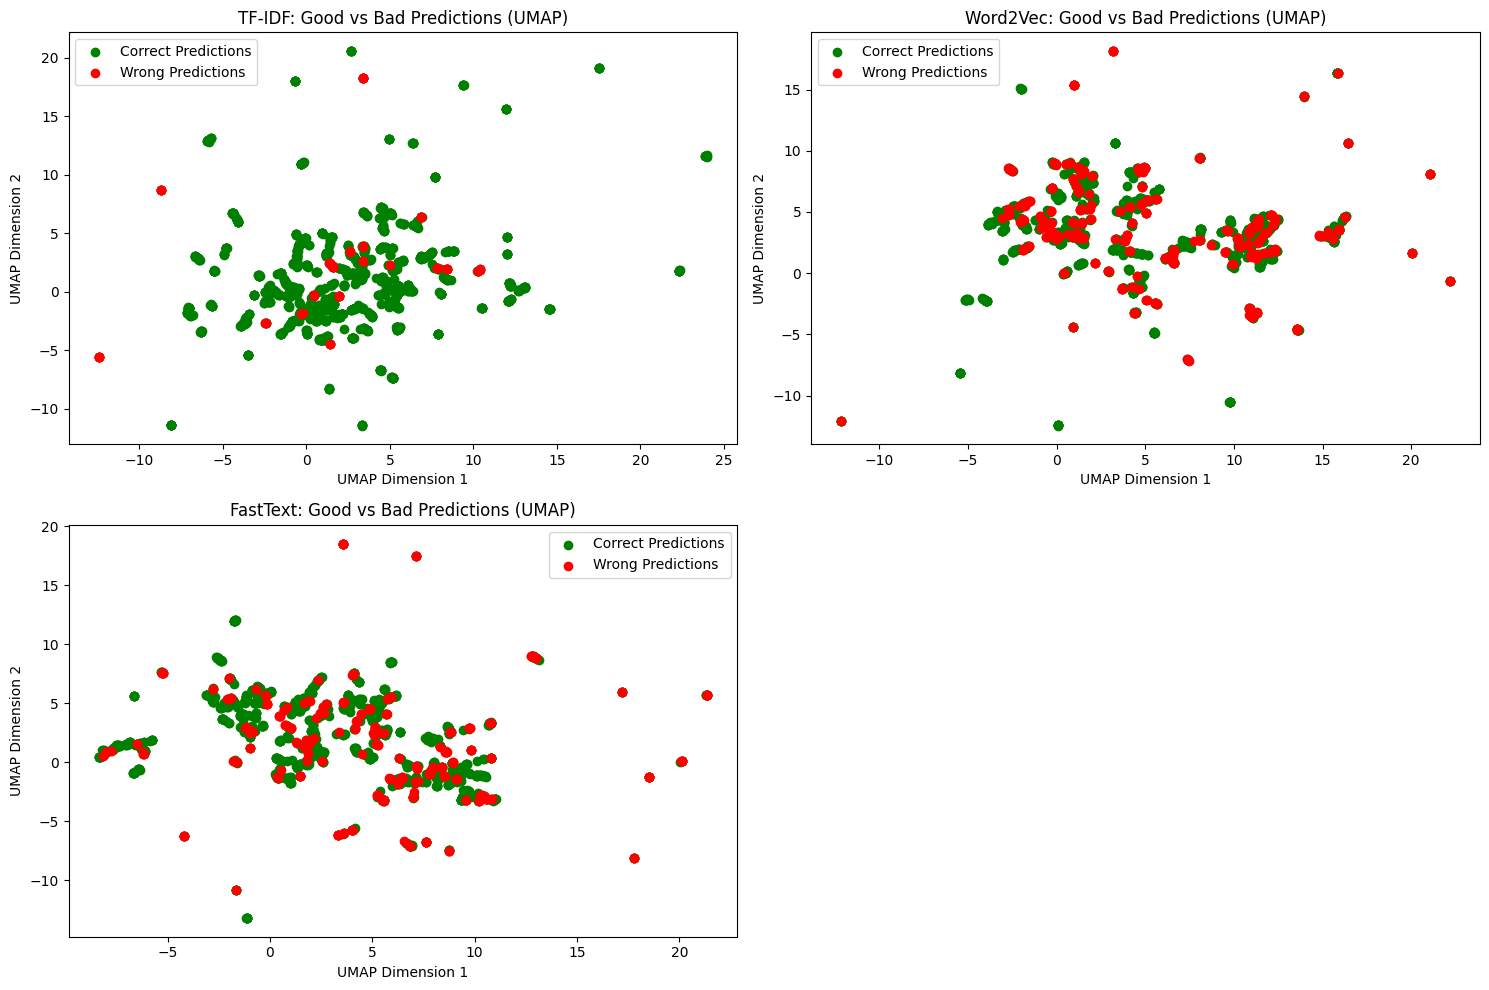

In [40]:
"""
    On veut représenter en 2D par un scatter plot les documents grâce à UMAP afin de voir la similarité des docuements en fonction de leur prédiction
    et également comment sont répartis les différentes prédictions (correctes ou incorrectes) en fonction des méthodes d'embedding (TF IDF, Word 2 Vec)
"""

X_tfidf_dense = X_test_tfidf.toarray()  # Convertir en matrice dense

# Application de UMAP pour réduire la dimensionnalité à 2D
umap_model = umap.UMAP(n_components=2, random_state=42)


X_umap_tfidf = umap_model.fit_transform(X_tfidf_dense)
X_umap_word2vec = umap_model.fit_transform(X_test_word2vec)
X_umap_fastext = umap_model.fit_transform(X_test_fastext)

# Comparaison avec les vrais labels
y_pred_wrong_tfidf = (y_pred_tfidf != y_test_tfidf)  # Mauvaises prédictions pour TF-IDF
y_pred_wrong_word2vec = (y_pred_word2vec != y_test_word2vec)  # Mauvaises prédictions pour Word2Vec
y_pred_wrong_fastext = (y_pred_fastext != y_test_fastext)  # Mauvaises prédictions pour Word2Vec

# Créer les subplots (2 lignes, 2 colonnes)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# TF-IDF
axs[0, 0].scatter(X_umap_tfidf[~y_pred_wrong_tfidf, 0], X_umap_tfidf[~y_pred_wrong_tfidf, 1], color='green', label='Correct Predictions')
axs[0, 0].scatter(X_umap_tfidf[y_pred_wrong_tfidf, 0], X_umap_tfidf[y_pred_wrong_tfidf, 1], color='red', label='Wrong Predictions')
axs[0, 0].set_title('TF-IDF: Good vs Bad Predictions (UMAP)')
axs[0, 0].set_xlabel('UMAP Dimension 1')
axs[0, 0].set_ylabel('UMAP Dimension 2')
axs[0, 0].legend()

# Word2Vec
axs[0, 1].scatter(X_umap_word2vec[~y_pred_wrong_word2vec, 0], X_umap_word2vec[~y_pred_wrong_word2vec, 1], color='green', label='Correct Predictions')
axs[0, 1].scatter(X_umap_word2vec[y_pred_wrong_word2vec, 0], X_umap_word2vec[y_pred_wrong_word2vec, 1], color='red', label='Wrong Predictions')
axs[0, 1].set_title('Word2Vec: Good vs Bad Predictions (UMAP)')
axs[0, 1].set_xlabel('UMAP Dimension 1')
axs[0, 1].set_ylabel('UMAP Dimension 2')
axs[0, 1].legend()

# FastText
axs[1, 0].scatter(X_umap_fastext[~y_pred_wrong_fastext, 0], X_umap_fastext[~y_pred_wrong_fastext, 1], color='green', label='Correct Predictions')
axs[1, 0].scatter(X_umap_fastext[y_pred_wrong_fastext, 0], X_umap_fastext[y_pred_wrong_fastext, 1], color='red', label='Wrong Predictions')
axs[1, 0].set_title('FastText: Good vs Bad Predictions (UMAP)')
axs[1, 0].set_xlabel('UMAP Dimension 1')
axs[1, 0].set_ylabel('UMAP Dimension 2')
axs[1, 0].legend()

# Supprimer le subplot vide
fig.delaxes(axs[1, 1])

# Affichage
plt.tight_layout()
plt.show()

- Nous voyons sur le premier graphique que les mauvaises prédictions sont pour la plupart similaires sur le plan 2D aux bonnes prédictions. Nous pouvons donc conclure que le modèle SVM couplé à la méthode TF-IDF est efficace.
- Cependant, sur le deuxième graphique, nous pouvons voir plusieurs mauvaises classifications qui sont similaires. Le modèle SVM associé à la méthode Word2Vec semble donc rencontrer des difficultés à classifier et séparer de manière efficace les différents types de documents en fonction de leurs label.

# 6. Theoretical formalism (TF-IDF)
 
### 1. Term Frequency (TF)
 
La fréquence de terme mesure l’importance locale d’un terme *t* dans un document *d* :
 
$$
\text{TF}(t, d) = \frac{f_{t,d}}{|d|}
$$
 
- \( f_{t,d} \) : Nombre d’occurrences du terme *t* dans le document *d*.
- \( |d| \) : Nombre total de termes dans *d* (longueur du document après prétraitement).
- **Rôle** : Normalise la fréquence brute pour tenir compte des différences de longueur entre les documents.
 
---
 
### 2. Inverse Document Frequency (IDF)
 
L’IDF mesure la rareté d’un terme *t* dans le corpus *D* :
 
$$
\text{IDF}(t, D) = \log \left(\frac{|D|}{n_t}\right)
$$
 
- \( |D| \) : Nombre total de documents.
- \( n_t = |\{ d \in D : t \in d \}| \) : Nombre de documents contenant *t*.
- **Rôle** : Réduit le poids des termes fréquents dans tout le corpus (e.g., "cancer", "patient") et augmente celui des termes rares et discriminants (e.g., "thyroidectomy").
 
---
 
### 3. TF-IDF Score
 
Le score TF-IDF combine les deux :
 
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
 
- **Propriété** : Les termes avec un score élevé sont ceux qui sont à la fois fréquents dans un document spécifique et rares dans le corpus global, idéal pour différencier les catégories *Thyroid_Cancer*, *Colon_Cancer*, et *Lung_Cancer*.
 
---
 
### 4. Vectorisation
 
Chaque document est représenté par un vecteur \( \mathbf{v}_d \) dans un espace de dimension \( |V| \) (taille du vocabulaire) :
 
$$
\mathbf{v}_d = [\text{TF-IDF}(t_1, d, D), \text{TF-IDF}(t_2, d, D), \ldots, \text{TF-IDF}(t_{|V|}, d, D)]
$$
 
- \( V \) : Vocabulaire unique extrait du corpus.  
- **Sparsité** : La majorité des entrées sont nulles, car un document ne contient qu’un sous-ensemble des termes.

# Conclusion

La combinaison de la méthode d'embedding TF-IDF et du modèle de classification permet d'obtenir une accuracy de **96%** sur nos documents médicaux.
Les articles traitant des 3 types de cancers sont classifiés avec un taux de réussite très satisfaisant, notamment pour les articles traitant du Lung Cancer qui sont parfaitement classifiés.